<a href="https://colab.research.google.com/github/ab17254/dissertation/blob/main/load_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "albrace"
os.environ['KAGGLE_KEY'] = "f9e1240f435d88603209646d4bc571a6"
!kaggle datasets download -d albrace/twitter-data

 96% 241M/252M [00:02<00:00, 140MB/s]
100% 252M/252M [00:02<00:00, 121MB/s]


In [2]:
!unzip /content/twitter-data.zip

Archive:  /content/twitter-data.zip
  inflating: all_twitter_data.csv    
  inflating: political_twitter_data.csv  


In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [67]:
pol_df = pd.read_csv('/content/political_twitter_data.csv')
all_df = pd.read_csv('/content/all_twitter_data.csv')

In [68]:
pol_df['tweet_date'] = pol_df['tweet_date'].map(lambda x: str(x)[:-15])
all_df['tweet_date'] = all_df['tweet_date'].map(lambda x: str(x)[:-15])


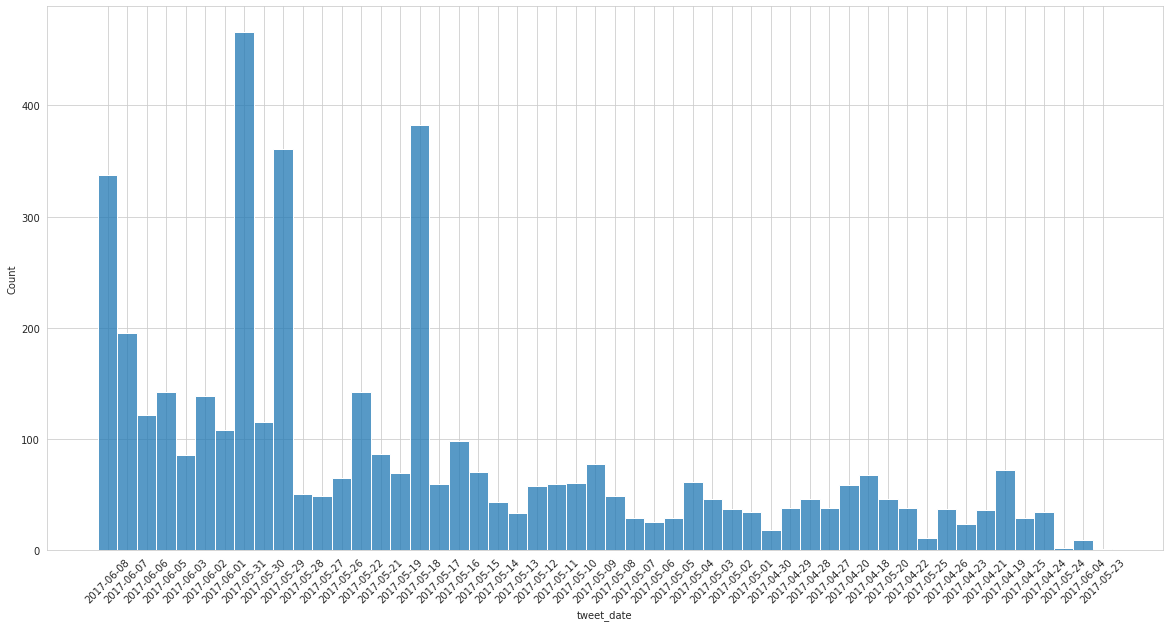

In [69]:
fig, ax = plt.subplots(figsize=(20,10))
g = sns.histplot(data=pol_df, x='tweet_date')
plt.setp(g.get_xticklabels(), rotation=45)
plt.show()

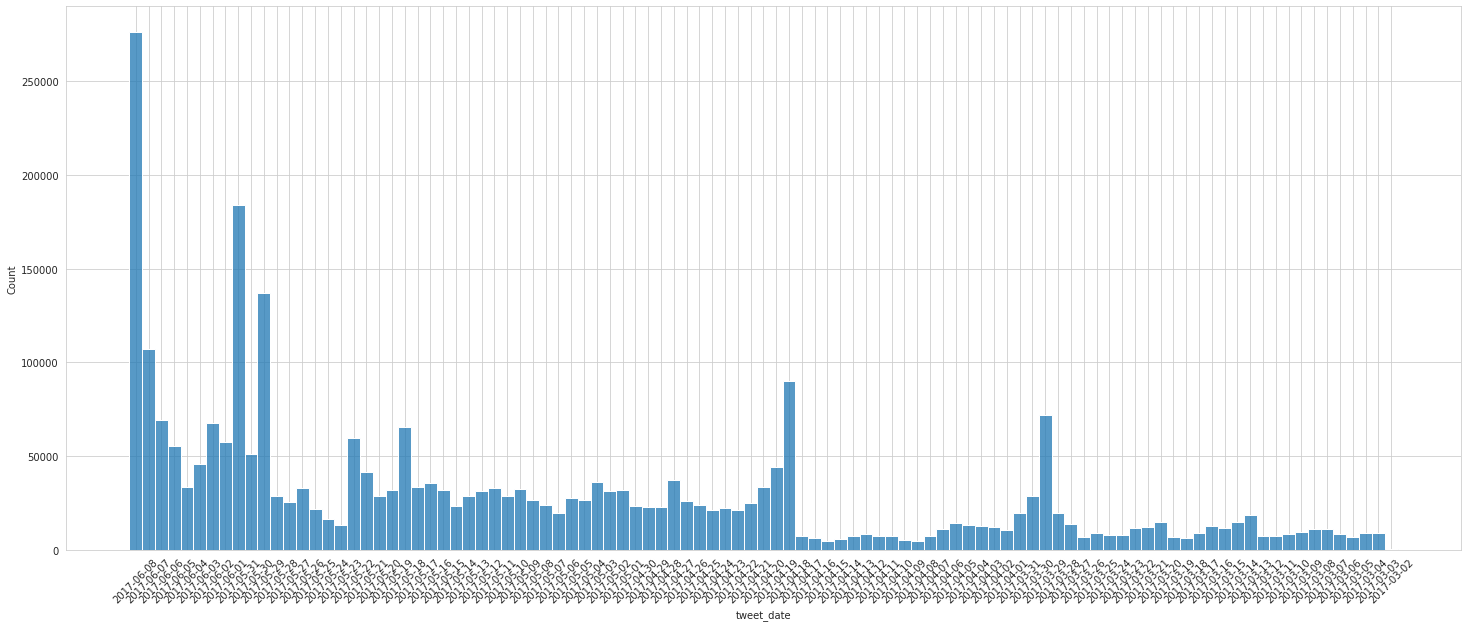

In [71]:
fig, ax = plt.subplots(figsize=(25,10))
g = sns.histplot(data=all_df, x='tweet_date')
plt.setp(g.get_xticklabels(), rotation=45)
plt.show()